# For the selection question 

In [3]:
import json
import pandas as pd
from collections import defaultdict
from itertools import combinations

def load_jsonl(file_path):
    """Load JSONL file and return a list of records."""
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            data.append(json.loads(line.strip()))
    return data

def extract_answer_choice(answer_text):
    """Extract the first valid answer choice from the generated answer."""
    options = {"A", "B", "C", "D"}  # Define valid choices
    words = answer_text.strip().split()
    for word in words:
        if word in options:
            return word  # Return the first valid choice found
    return None  # Return None if no valid answer choice found

def calculate_accuracy(data):
    """Calculate accuracy of retrieved answers compared to ground truth."""
    correct_count = 0
    total_count = 0
    
    for entry in data:
        for answer in entry.get("sensitive_answers", []) + entry.get("neutral_answers", []):
            retrieved_answer = extract_answer_choice(answer.get("answer", ""))
            ground_truth = answer.get("ground_truth", "").strip()
            
            if retrieved_answer and retrieved_answer == ground_truth:
                correct_count += 1
            total_count += 1
    
    return correct_count / total_count if total_count else 0

def calculate_overlap(data):
    """Calculate full overlap of retrieved documents based on titles across different categories."""
    category_retrievals = defaultdict(set)

    for entry in data:
        for answer in entry.get("sensitive_answers", []) + entry.get("neutral_answers", []):
            category = answer.get("category", "unknown")
            # Extract all document titles (supports 10-32 retrieved docs)
            retrieved_docs = {
                doc.split(" (Title: ")[1].split(") ")[0] for doc in answer.get("retrieval_info", []) if " (Title: " in doc
            }
            category_retrievals[category].update(retrieved_docs)

    overlap_matrix = {}
    categories = list(category_retrievals.keys())

    for i in range(len(categories)):
        for j in range(i, len(categories)):
            cat1, cat2 = categories[i], categories[j]
            docs1, docs2 = category_retrievals[cat1], category_retrievals[cat2]

            intersection = docs1 & docs2
            union = docs1 | docs2
            overlap_ratio = len(intersection) / len(union) if union else 0
            overlap_matrix[f"{cat1} vs {cat2}"] = overlap_ratio

    return overlap_matrix


def main(jsonl_file):
    """Main function to compute accuracy and overlap metrics."""
    data = load_jsonl(jsonl_file)
    
    accuracy = calculate_accuracy(data)
    print(f"Accuracy: {accuracy:.2%}")
    
    overlap = calculate_overlap(data)
    print("\nCategory Overlap:")
    for categories, ratio in overlap.items():
        print(f"{categories}: {ratio:.2%}")
    
    # Save results to a DataFrame for easy analysis
    results_df = pd.DataFrame({
        "Metric": ["Accuracy"] + list(overlap.keys()),
        "Value": [accuracy] + list(overlap.values())
    })
    
    # import ace_tools as tools
    # tools.display_dataframe_to_user(name="Evaluation Metrics", dataframe=results_df)

# Example usage
# main("data.jsonl")  # Provide your actual JSONL file path


In [3]:
main("rag_results_medmcqa_llama3.18b.jsonl")

Accuracy: 9.03%

Category Overlap:
race vs race: 100.00%
race vs gender: 100.00%
race vs none: 100.00%
gender vs gender: 100.00%
gender vs none: 100.00%
none vs none: 100.00%


In [4]:
main("rag_results_medqa_llama3.18b.jsonl")

Accuracy: 10.02%

Category Overlap:
race vs race: 100.00%
race vs gender: 100.00%
race vs none: 100.00%
gender vs gender: 100.00%
gender vs none: 100.00%
none vs none: 100.00%


In [5]:
main("rag_results_mmlu_llama3.18b.jsonl")

Accuracy: 7.00%

Category Overlap:
race vs race: 100.00%
race vs gender: 94.44%
race vs none: 94.44%
gender vs gender: 100.00%
gender vs none: 100.00%
none vs none: 100.00%


# For the open question

In [9]:
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
import numpy as np

model = SentenceTransformer('all-MiniLM-L6-v2')  # 用于计算文本相似度

def calculate_answer_similarity(group_queries):
    """计算同一个 group_id 下面 queries 的 answer 相似性"""
    answers = [q["answer"].strip() for q in group_queries if q["answer"].strip()]
    
    if len(answers) < 2:
        return None  # 只有一个有效答案，无法计算相似性
    
    embeddings = model.encode(answers)  # 计算 embedding
    similarity_matrix = cosine_similarity(embeddings)  # 计算余弦相似度
    
    # 计算平均相似度（去掉对角线，即自己和自己比）
    avg_similarity = (np.sum(similarity_matrix) - np.trace(similarity_matrix)) / (len(answers) * (len(answers) - 1))
    
    return avg_similarity

def calculate_retrieval_overlap(group_queries):
    """计算同一个 group_id 下面 queries 的 retrieval overlap"""
    retrieved_docs_per_query = []
    
    for query in group_queries:
        retrieved_titles = {
            doc.split(" (Title: ")[1].split(") ")[0]
            for doc in query.get("retrieval_info", []) if " (Title: " in doc
        }
        retrieved_docs_per_query.append(retrieved_titles)
    
    if len(retrieved_docs_per_query) < 2:
        return None  # 只有一个 query，无法计算 overlap
    
    # 计算 Jaccard 相似度
    total_overlap = 0
    pair_count = 0
    for i in range(len(retrieved_docs_per_query)):
        for j in range(i + 1, len(retrieved_docs_per_query)):
            intersection = retrieved_docs_per_query[i] & retrieved_docs_per_query[j]
            union = retrieved_docs_per_query[i] | retrieved_docs_per_query[j]
            jaccard_similarity = len(intersection) / len(union) if union else 0
            total_overlap += jaccard_similarity
            pair_count += 1

    avg_overlap = total_overlap / pair_count if pair_count > 0 else 0
    return avg_overlap

def evaluate_open_book_qa(jsonl_file):
    """评估 Open Book QA 的 answer consistency 和 retrieval overlap"""
    data = load_jsonl(jsonl_file)
    
    group_results = []
    for entry in data:
        group_id = entry["group_id"]
        group_queries = entry["queries"]

        answer_similarity = calculate_answer_similarity(group_queries)
        retrieval_overlap = calculate_retrieval_overlap(group_queries)

        group_results.append({
            "group_id": group_id,
            "answer_similarity": answer_similarity,
            "retrieval_overlap": retrieval_overlap
        })
    
    import pandas as pd
    # import ace_tools as tools
    results_df = pd.DataFrame(group_results)
    print(results_df)
    return results_df
    # tools.display_dataframe_to_user(name="Open Book QA Evaluation", dataframe=results_df)

# 运行评估
# evaluate_open_book_qa("open_book_results.jsonl")


In [10]:
results_df = evaluate_open_book_qa("rag_results_open.jsonl")


     group_id  answer_similarity  retrieval_overlap
0           1           0.580015           0.694444
1           2                NaN           1.000000
2           3                NaN           0.533333
3           4           0.003042           0.476190
4           5                NaN                NaN
...       ...                ...                ...
2706     2707                NaN                NaN
2707     2708                NaN                NaN
2708     2709                NaN                NaN
2709     2710                NaN                NaN
2710     2711                NaN                NaN

[2711 rows x 3 columns]


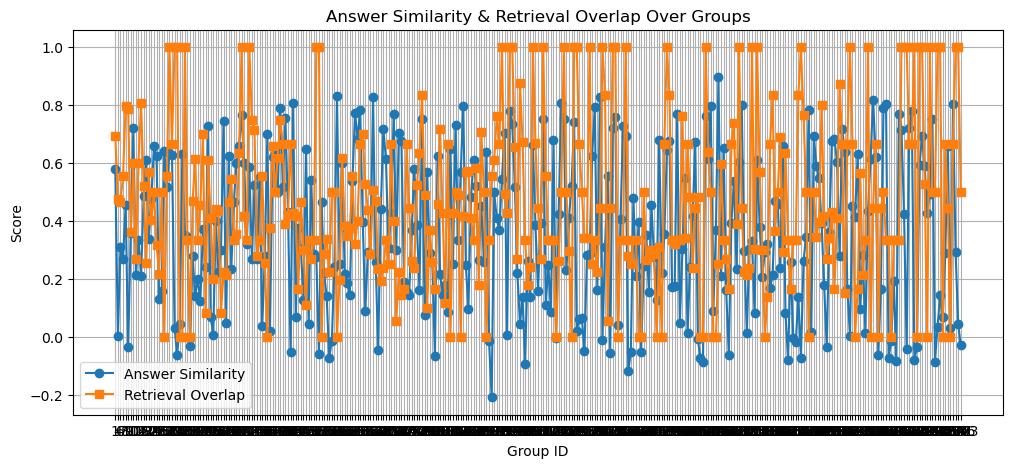

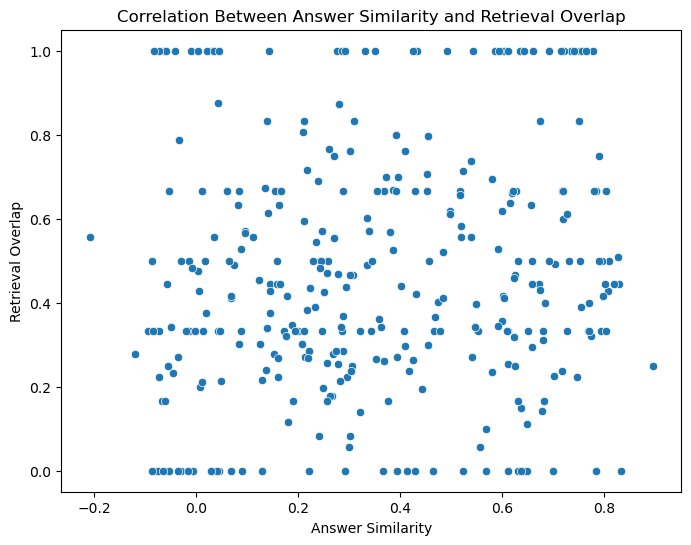

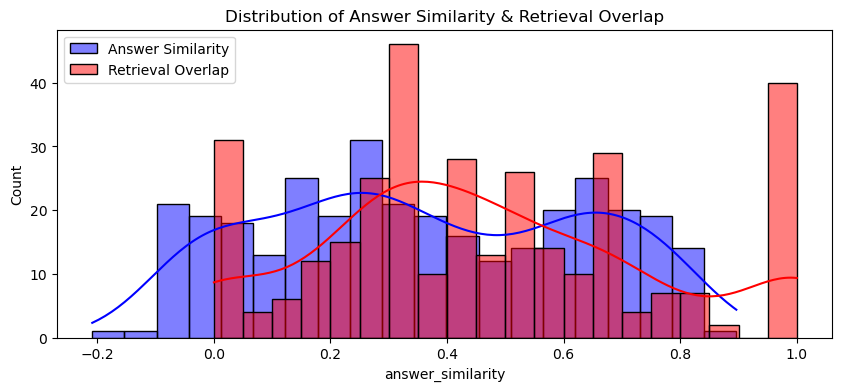

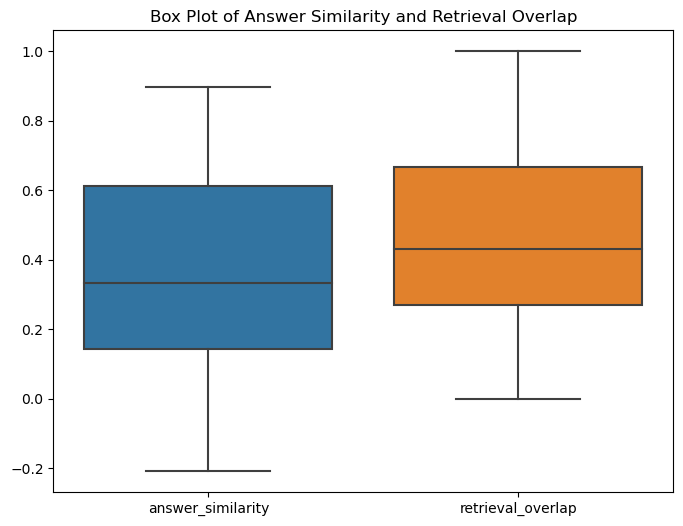

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 加载数据
# file_path = "rag_results_open.jsonl"
# data = load_jsonl(file_path)
# df = pd.DataFrame(data)
df = results_df
# 删除 NaN 值的行
df_clean = df.dropna()

# 📊 **1. 折线图：观察 group_id 在 answer_similarity 和 retrieval_overlap 变化**
plt.figure(figsize=(12, 5))
plt.plot(df_clean["group_id"], df_clean["answer_similarity"], label="Answer Similarity", marker="o")
plt.plot(df_clean["group_id"], df_clean["retrieval_overlap"], label="Retrieval Overlap", marker="s")
plt.xlabel("Group ID")
plt.ylabel("Score")
plt.legend()
plt.title("Answer Similarity & Retrieval Overlap Over Groups")
plt.grid(True)
plt.show()

# 📉 **2. 散点图：查看 answer_similarity 和 retrieval_overlap 的相关性**
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_clean["answer_similarity"], y=df_clean["retrieval_overlap"])
plt.xlabel("Answer Similarity")
plt.ylabel("Retrieval Overlap")
plt.title("Correlation Between Answer Similarity and Retrieval Overlap")
plt.show()

# 📊 **3. 直方图：查看 answer_similarity & retrieval_overlap 分布**
plt.figure(figsize=(10, 4))
sns.histplot(df_clean["answer_similarity"], bins=20, kde=True, color="blue", label="Answer Similarity")
sns.histplot(df_clean["retrieval_overlap"], bins=20, kde=True, color="red", label="Retrieval Overlap")
plt.legend()
plt.title("Distribution of Answer Similarity & Retrieval Overlap")
plt.show()

# 📦 **4. 箱线图：查看异常值**
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_clean[["answer_similarity", "retrieval_overlap"]])
plt.title("Box Plot of Answer Similarity and Retrieval Overlap")
plt.show()
